In [1]:
from catboost import CatBoostClassifier
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
user_data = pd.read_csv('data\\user_data\\user_data_features.csv',
                        index_col='user_id')

user_data.head()

,age,country,city,business_activity,covid_activity,entertainment_activity,movie_activity,politics_activity,sport_activity,tech_activity,user_total_activity
user_id,,,,,,,,,,,
82908,35,0.112296,0.154482,0.069767,0.194030,0.074074,0.230216,0.088496,0.101695,0.142857,0.147841
55992,21,0.112296,0.101416,0.166667,0.148148,0.076923,0.125714,0.129032,0.222222,0.090909,0.139706
289,45,0.112296,0.130103,0.086957,0.103093,0.000000,0.100000,0.074074,0.022222,0.150000,0.084615
125840,38,0.112296,0.071006,0.000000,0.073171,0.111111,0.084507,0.000000,0.000000,0.000000,0.056818
104581,22,0.112296,0.154482,0.090909,0.183673,0.200000,0.137931,0.272727,0.375000,0.000000,0.186747


In [3]:
post_data_TFIDF = pd.read_csv('data\\post_data\\post_data_TFIDF_features.csv',
                              index_col='post_id')

post_data_TFIDF.head()

,topic,views,likes_percent,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10
post_id,,,,,,,,,,,,,
1,0.119166,484,0.128099,-0.087008,0.151647,-0.000607,-0.083132,-0.217895,0.079521,0.219510,0.002372,0.045834,-0.150027
2,0.119166,423,0.080378,-0.083853,0.194422,0.051568,0.037130,-0.058422,0.017237,-0.002660,-0.021204,0.016901,-0.006666
3,0.119166,513,0.152047,-0.063860,0.105556,-0.009263,-0.086243,-0.197605,0.020544,0.125654,0.016732,-0.000823,-0.011859
4,0.119166,522,0.139847,-0.076315,0.089829,0.001503,-0.048643,-0.147690,-0.000524,0.028847,0.025491,0.000988,0.065877
5,0.119166,513,0.120858,-0.059094,0.051467,-0.004680,-0.030744,-0.057165,-0.016601,-0.035494,-0.016148,-0.026589,0.039654


In [4]:
feed_data = pd.read_csv('data\\feed_data\\feed_data_features.csv')

feed_data.head()

,user_id,post_id,target,hour,data
0,100142,5951,0,7,20211002
1,100142,5883,0,7,20211002
2,100142,1935,0,7,20211002
3,100142,3498,0,7,20211002
4,100142,4794,0,7,20211002


# Разбиение выборки на train и test

Поскольку данные имеют временную структуру, будем тренироваться на ранних датах, предсказывать на поздних

In [5]:
sep_data = int(feed_data.data.quantile(q=0.67))
sep_data

20211130

In [6]:
train = user_data \
    .merge(feed_data[feed_data.data<=sep_data], how='left', on='user_id') \
    .merge(post_data_TFIDF, how='left', on='post_id') \
    .set_index(['user_id', 'post_id']) \
    .dropna()

X_train = train.drop(columns='target')
Y_train = train['target']


test = user_data \
    .merge(feed_data[feed_data.data>sep_data], how='left', on='user_id') \
    .merge(post_data_TFIDF, how='left', on='post_id') \
    .set_index(['user_id', 'post_id']) \
    .dropna()

X_test = test.drop(columns='target')
Y_test = test['target']

In [7]:
X_train.sample(3)

,,age,country,city,business_activity,covid_activity,entertainment_activity,movie_activity,politics_activity,sport_activity,tech_activity,...,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10
user_id,post_id,,,,,,,,,,,,,,,,,,,,,
141561,158,23,0.190263,0.226426,0.350877,0.200000,0.276923,0.190164,0.230769,0.400000,0.095238,...,-0.062911,0.114986,0.006689,-0.030815,-0.057700,-0.017779,-0.025318,0.010137,0.011044,0.046389
51979,3503,17,0.190263,0.155231,0.076923,0.109677,0.071429,0.124444,0.219512,0.166667,0.100000,...,-0.152512,-0.111880,0.027029,0.028162,0.006152,0.015709,0.020985,0.007726,0.023294,-0.027108
75169,7053,22,0.112296,0.078631,0.000000,0.061728,0.000000,0.032520,0.115385,0.048193,0.040000,...,0.155028,-0.047157,0.124784,-0.023220,-0.000785,-0.008149,-0.012413,0.008933,0.002243,0.004055


# Обучение модели
Для начала определим метрику, на которую будем ориентироваться.

Данной метрикой будет `hitrate@5`, но также будем ориентироваться на `hitrate@3` и `hitrate@1`.

Модель будет предсказывать n постов, которые пользователь лайкнет вероятнее всего.

Метрика `hitrate@n` работает следующим образом: если пользователю среди предпложенных n постов попадается хотя бы один, который он лайкнет, то метрика принимает значение 1, иначе 0. Потом усредняем значение по пользователям.

In [8]:
def ML_hitrate_n(model, x, y, n):
    check = pd.concat([y,
                       pd.Series(model.predict_proba(x)[:,1], index=y.index, name='probas')],
                      axis=1)
    
    check = check.reset_index().drop(columns='post_id')
    
    pred_list = [check[check.user_id == user_id].sort_values('probas', ascending=False).iloc[:n]
                 for user_id in tqdm(check.user_id.unique(), desc=f"hitrate@{n}_eval")]

    return pd.concat(pred_list).groupby('user_id').target.sum().map(lambda x: min(1, x)).mean()

## CatBoostClassifier
При обучении будем ориентироваться на метрику `PR-AUC`, которая поможет нам избежать переобучения

In [9]:
ML_model = CatBoostClassifier(num_trees=1000,
                              eval_metric='PRAUC',
                              auto_class_weights='Balanced',)

ML_model.fit(X_train, Y_train, eval_set=(X_test, Y_test), verbose=50, early_stopping_rounds=25)

Learning rate set to 0.226328
0:	learn: 0.6718951	test: 0.7044432	best: 0.7044432 (0)	total: 983ms	remaining: 16m 21s
50:	learn: 0.7046235	test: 0.7280553	best: 0.7280553 (50)	total: 57.4s	remaining: 17m 48s
100:	learn: 0.7124795	test: 0.7346697	best: 0.7346697 (100)	total: 1m 58s	remaining: 17m 30s
150:	learn: 0.7164348	test: 0.7372683	best: 0.7372683 (150)	total: 2m 58s	remaining: 16m 41s
200:	learn: 0.7186830	test: 0.7379522	best: 0.7379526 (198)	total: 4m 1s	remaining: 15m 58s
250:	learn: 0.7202508	test: 0.7381370	best: 0.7381783 (237)	total: 5m 3s	remaining: 15m 4s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.7381783381
bestIteration = 237

Shrink model to first 238 iterations.


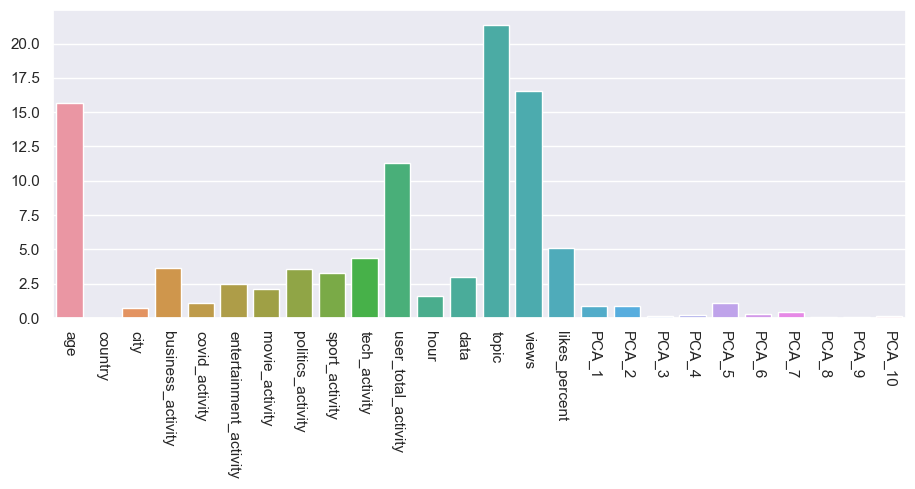

In [10]:
sns.set(rc={"figure.figsize":(11, 4)})
sns.barplot(x=ML_model.feature_names_, y=ML_model.feature_importances_)
plt.xticks(rotation=-90);

In [11]:
for n in [1, 3, 5]:
    print(f"hitrate@{n} = {ML_hitrate_n(ML_model, X_test, Y_test, n):.3f}")

hitrate@1_eval: 100%|█████████████████████████████████████████████████████████████| 9824/9824 [00:35<00:00, 278.53it/s]


hitrate@1 = 0.319


hitrate@3_eval: 100%|█████████████████████████████████████████████████████████████| 9824/9824 [00:37<00:00, 265.22it/s]


hitrate@3 = 0.654


hitrate@5_eval: 100%|█████████████████████████████████████████████████████████████| 9824/9824 [00:36<00:00, 271.88it/s]


hitrate@5 = 0.813


В принципе неплохо, модель не переобучается и показывает высокое значение метрик `hitrate@n`

Напомню, что задачей было пробить качество `hitrate@5 >= 0.4`, а получилось пробить качество `0.4` даже на `hitrate@3`